# Assignment 3: Flipping Cholesterols

By Koen Westendorp (s3950808)

2022-04-04

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Molecular Dynamics data

In [2]:
file_path = "./chol-z.dat"
df = pd.read_csv(file_path, skiprows=2, header=None, dtype=float, sep=r'\s+')
#df

## Visualizing the data

In [3]:
time =   np.array(df[0])  # time (ps)
center = np.array(df[1])  # z-position of bilayer center (nm)
chol_position_frames = df[range(2, df.shape[1])] # z-position of cholesterol's head oxygen (nm). One column per cholesterol

M = np.array(chol_position_frames).T

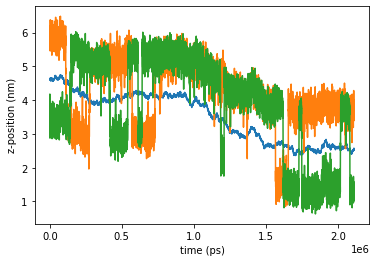

In [4]:
fig, ax = plt.subplots()
ax.set_ylabel("z-position (nm)")
ax.set_xlabel("time (ps)")
plt.plot(time, center)
plt.plot(time, M[0])
plt.plot(time, M[100])
plt.show()

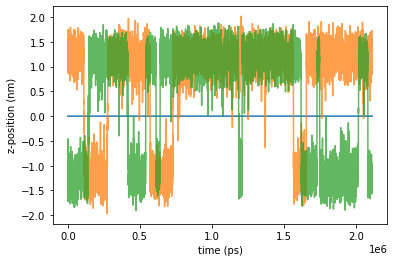

In [5]:
dist_from_center = M - (center * np.ones_like(M))

fig, ax = plt.subplots()
ax.set_ylabel("z-position (nm)")
ax.set_xlabel("time (ps)")
plt.plot(time, np.zeros_like(time))
plt.plot(time, dist_from_center[0], alpha=0.75)
plt.plot(time, dist_from_center[100], alpha=0.75)
plt.show()

## Counting flips

In [6]:
D = np.array([[1, 2, -2], [-1, 1, 2], [-2, -3, -1]])
D = dist_from_center

offset = 1
D_offset = np.roll(D, offset, axis=0)

D_mask = D > 0
D_offset_mask = D_offset > 0

total_flips = np.roll(D_mask != D_offset_mask, -offset, axis=0)[:-1]
n_total_flips = np.sum(total_flips, axis=0)

up_flips = np.roll(D_mask > D_offset_mask, -offset, axis=0)[:-1]
n_up_flips = np.sum(up_flips, axis=0)

down_flips = np.roll(D_mask < D_offset_mask, -offset, axis=0)[:-1]
n_down_flips = np.sum(down_flips, axis=0)

# n_total_flips, n_up_flips, n_down_flips

In [7]:
total_us = (time[-1] - time[0]) / 1_000_000

total_flips_per_us = n_total_flips / total_us
up_flips_per_us = n_up_flips / total_us
down_flips_per_us = n_down_flips / total_us

# total_flips_per_us, up_flips_per_us, down_flips_per_us

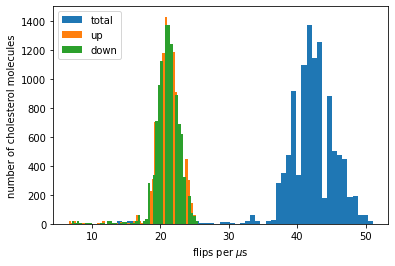

In [8]:
n_chols = chol_position_frames.shape[0]

fig, ax = plt.subplots()
ax.set_ylabel("number of cholesterol molecules")
ax.set_xlabel("flips per $\mu$s")
plt.hist(total_flips_per_us, bins=50)
plt.hist(up_flips_per_us, bins=50)
plt.hist(down_flips_per_us, bins=50)
ax.legend(["total", "up", "down"])
plt.show()

## Residence times

In [9]:
def residence_time(flip_times):
    times_list = [t for t in flip_times if t > 0]
    residence_times = []
    prev = 0
    for t in times_list:
        residence_times.append((t - prev) / 1_000_000)
        prev = t
        
    return residence_times

def average_residence_time(residence_times):
    avg_residence_times = [sum(residence_time) / len(residence_times) for residence_time in residence_times]
    return sum(avg_residence_times) / len(residence_times)

def filter_and_flatten(times, threshold):
    flatten = lambda l: [i for sublist in l for i in sublist]
    flattened_times = flatten(list(times))
    criterion = lambda v: v > threshold
    return list(filter(criterion, flattened_times))

def plot_residence_time_distribution(residence_times, threshold):
    xlabel = f"residence time ($\mu$s) [$\greater {threshold}$]"

    ax1 = plt.subplot(121)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel("number of cholesterol molecules")
    plt.hist(residence_times, bins=50, log=True)

    ax2 = plt.subplot(122, sharex=ax1)
    ax2.set_xlabel(xlabel)
    plt.hist(residence_times, bins=50, log=False)

    plt.show()

def present_average_residence_time(residence_times, decimals=6):
    print(f"Average residence time between flips: {round(average_residence_time(residence_times), decimals)} 𝜇s")

Average residence time between flips: 0.011606 𝜇s


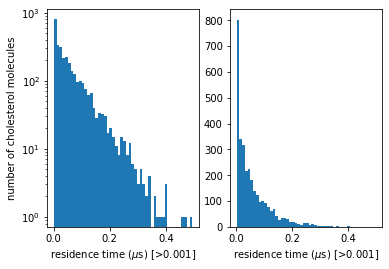

In [10]:
threshold = 0.001

chols_flip_times = list((time * total_flips))
chols_residence_times = [residence_time(chol_flip_times) for chol_flip_times in chols_flip_times]
present_average_residence_time(chols_residence_times)
chols_residence_times = filter_and_flatten(chols_residence_times, threshold)
plot_residence_time_distribution(chols_residence_times, threshold)

## Making the analysis more robust

In [11]:
def flip_times_buffered(time, D, buffer):
    """
    Parameters
    ----------
    buffer : float
        Region extending from each side of the bilayer center in nanometers.
        
    Returns
    -------
    [array[float]]
    """
    flips = []
    for cholesterol in D:
        flip_moments = []
        above = cholesterol[0] > 0
        for t, z in zip(time, cholesterol):
            # If the z-value is greater than the buffer distance from the bilayer center, 
            # it is considered to be above it, and vice versa for z-values below the center.
            # In such a condition, it might be the case that `above` is changed, because the
            # z-value crossed over the z_center + buffer barrier. In this case, the time 
            # point `t` is appended to `flip_moments`.
            # Else, when z_center + buffer < z < z_center - buffer, do nothing. The value
            # of `above` is left the same.
            if z > buffer:
                if not above:
                    flip_moments.append(t)
                above = True
            elif z < buffer:
                if above:
                    flip_moments.append(t)
                above = False

        flips.append(flip_moments)
    
    return flips

### No buffer zone

$\textit{buffer} = 0.0\ \text{nm}$

Average residence time between flips: 0.011015 𝜇s


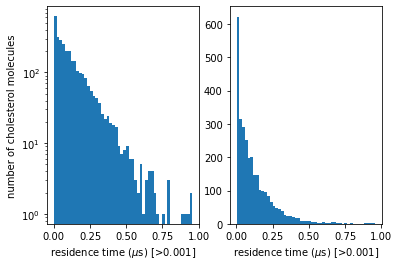

In [12]:
chols_flip_times = flip_times_buffered(time, D, 0.)
chols_residence_times = [residence_time(chol_flip_times) for chol_flip_times in chols_flip_times]
present_average_residence_time(chols_residence_times)
chols_residence_times = filter_and_flatten(chols_residence_times, threshold)
plot_residence_time_distribution(chols_residence_times, threshold)

### With buffer zone

$\textit{buffer} = 0.8\ \text{nm}$

Average residence time between flips: 0.011054 𝜇s


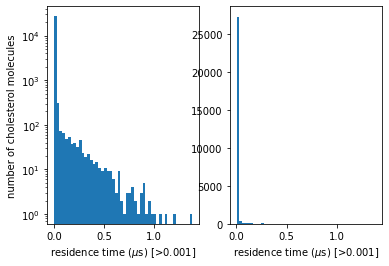

In [13]:
chols_flip_times = flip_times_buffered(time, D, 0.8)
chols_residence_times = [residence_time(chol_flip_times) for chol_flip_times in chols_flip_times]
present_average_residence_time(chols_residence_times)
chols_residence_times = filter_and_flatten(chols_residence_times, threshold)
plot_residence_time_distribution(chols_residence_times, threshold)